# Cats vs. Dogs Image Classifier


In [1]:
# Tools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# ML
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

import random
import cv2
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Activation
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet152V2

np.random.seed(42)
tf.random.set_seed(42)


### Import Kaggle Data

In [2]:
# upload kaggle.json first
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

100% 811M/814M [00:09<00:00, 81.9MB/s]
100% 814M/814M [00:09<00:00, 85.5MB/s]


In [4]:
! unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [5]:
%%capture
! unzip test.zip
! unzip train.zip

In [ ]:
os.getcwd()

'/content'

## Data Processing
Some code used from https://keras.io/examples/vision/image_classification_from_scratch/

In [6]:
# Move labelled train images to labelled folders

train_folder = 'train/'
train_images = [i for i in os.listdir(train_folder)]
#print(train_images[0:10])
dog = 'train/dog'
cat = 'train/cat'
os.mkdir(dog)
os.mkdir(cat)

In [7]:
for image in train_images:
  if 'dog' in image:
    os.replace(os.path.join(train_folder, image), os.path.join(dog, image))
  elif 'cat' in image:
    os.replace(os.path.join(train_folder, image), os.path.join(cat, image))

In [8]:
# Move test images to test folder
test_images = [i for i in os.listdir('test/')]
os.mkdir('test/test_images')
for image in test_images:
  os.replace(os.path.join('test/', image), os.path.join('test/test_images', image))


## Setup Data pipeline for Model

In [9]:
train_image_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True, validation_split=0.2)
test_image_gen = ImageDataGenerator(rescale=1/255)

Information about Resnet suggests it was pretrained on an imageset that is 224x224 pixels, so we will use that size as our baseline for our image resizing.

In [10]:
image_size = (224, 224)
batch_size = 64

train_generator = train_image_gen.flow_from_directory(
    'train',
    target_size=image_size,
    batch_size=batch_size,
    seed=12,
    subset='training',
    shuffle=True,
    class_mode='binary'
)
val_generator = train_image_gen.flow_from_directory(
    'train',
    target_size=image_size,
    batch_size=batch_size,
    seed=12,
    subset='validation',
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_gen.flow_from_directory(
    'test',
    target_size=image_size,
    batch_size=1,
    seed=12,
    class_mode=None,
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


# Keras ResNet152V2

The final model I chose to use for this competition wass the ResNet152V2 architecture. This was chosen because of it's depth, the pretrained weights available, and strong performance on image classification.

In [11]:
resnet = ResNet152V2(
    include_top=False,
    weights='imagenet'
)

234561536/234545216 [==============================] - 4s 0us/step


In [12]:
len(resnet.layers)

564

There are 564 layers within the Resnet152v2, so I experimented with setting different amounts of these layers as trainable and not trainable. A configuration that worked well was freezing the first 95% of these layers, then setting the remaining 5% as trainable. This captured most of the existing pretrained weights, while allowing flexibility for the model to learn on our image dataset and improve.

In [ ]:
# 564 resnet layers total
for layer in resnet.layers[:535]:
    layer.trainable =False
for layer in resnet.layers[535:]:
    layer.trainable=True


x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation= 'sigmoid')(x)
model = tf.keras.Model(inputs = resnet.input, outputs = predictions)

model.summary()

To improve our model tuning, I also implemented early stopping, and LR modifications in order to not overfit our data and achieve the best possible validation accuracy.

Because this is a transfer learning problem and we are using pretrained weights, I also set the learning rate for the Adam optimizer to half its default value, 0.0005.

In [14]:
LR = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=.5, min_lr=.00001)
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

epochs = 15

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[EarlyStop, LR],
    validation_data=val_generator
)


Epoch 1/15
313/313 [==============================] - 130s 357ms/step - loss: 0.0531 - accuracy: 0.9807 - val_loss: 0.0373 - val_accuracy: 0.9878 - lr: 5.0000e-04
Epoch 2/15
313/313 [==============================] - 111s 353ms/step - loss: 0.0201 - accuracy: 0.9927 - val_loss: 0.0460 - val_accuracy: 0.9832 - lr: 5.0000e-04
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9952
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
313/313 [==============================] - 108s 343ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.0499 - val_accuracy: 0.9852 - lr: 5.0000e-04
Epoch 4/15
313/313 [==============================] - 107s 341ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0403 - val_accuracy: 0.9882 - lr: 2.5000e-04
Epoch 5/15
313/313 [==============================] - 107s 340ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0432 - val_accuracy: 0.9900 - lr: 2.5000e-04
Epoch 6/15
313/313 [====

Some possible paramaters that I can tune for improving this model are as follows:


*   Image_Size = (224, 224)
*   Batch_Size = 64
*   Learning_Rate_init = 0.0005
*   Frozen Resnet Layers = [:535]

In further improvements of this model, Keras Tuner can be used to find the best options.


In [15]:
# Save Model
model.save('resnet152v2')

INFO:tensorflow:Assets written to: resnet152v2/assets


In [16]:
!zip -r /content/resnet152v2.zip /content/resnet152v2

  adding: content/resnet152v2/ (stored 0%)
  adding: content/resnet152v2/keras_metadata.pb (deflated 96%)
  adding: content/resnet152v2/variables/ (stored 0%)
  adding: content/resnet152v2/variables/variables.index (deflated 82%)
  adding: content/resnet152v2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/resnet152v2/assets/ (stored 0%)
  adding: content/resnet152v2/saved_model.pb (deflated 93%)


In [ ]:
# Optional import model
from keras.models import load_model
model = load_model('model.hd5')

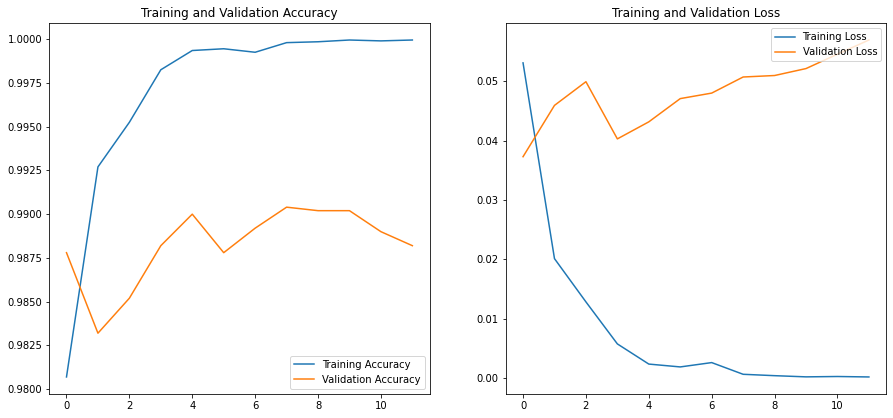

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

n_ep = len(history.history['loss'])
epochs_range = range(n_ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Validate Model on Test Data

In [18]:
predictions = model.predict(test_generator,verbose=1)

12500/12500 [==============================] - 310s 25ms/step


In [19]:
import re

image_index = []
for i in test_generator.filenames:
  image_index += [int(s) for s in re.findall(r'\b\d+\b', i)]

print(image_index[0:10])

[1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10005]


In [20]:
pred_tuples = list(zip(image_index, predictions.flatten().tolist()))
pred = pd.DataFrame(pred_tuples, columns=['id','label'])
pred = pred.sort_values(by='id')
print(pred[:5])

      id         label
0      1  9.999999e-01
3612   2  1.000000e+00
4723   3  9.999992e-01
5834   4  1.000000e+00
6945   5  4.059837e-07


From Source: https://medium.com/@egor_vorobiev/how-to-improve-log-loss-score-kaggle-trick-3f95577839f1

Kaggle uses Log-loss scoring, so we can improve our score marginally by eliminating the extremely high confidence predictions our model is making through the clip function.

In [21]:
pred['label'] = pred['label'].clip(0.005, 0.995)
print(pred[:5])

      id  label
0      1  0.995
3612   2  0.995
4723   3  0.995
5834   4  0.995
6945   5  0.005


In [22]:
pred.to_csv('result.csv', index=False)

In [23]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f result.csv -m "Message"

100% 139k/139k [00:02<00:00, 56.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/leaderboard

Score: 0.05538

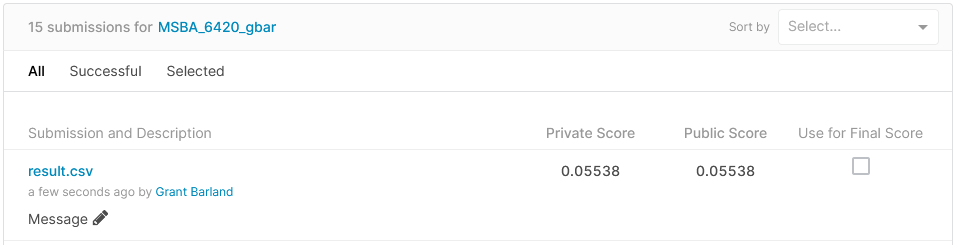

# Unused Code

### Manual Data Processing

In [ ]:
#train_folder = 'drive/MyDrive/Colab Data/HW4/train/'
#test_folder = 'drive/MyDrive/Colab Data/HW4/test/'
train_folder = 'train/'
test_folder = 'test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [train_folder+i for i in os.listdir(train_folder)] # use this for full dataset
train_dogs =   [train_folder+i for i in os.listdir(train_folder) if 'dog' in i]
train_cats =   [train_folder+i for i in os.listdir(train_folder) if 'cat' in i]

test_images =  [test_folder+i for i in os.listdir(test_folder)]

print(f'length of train: {len(train_images)}')
print(f'length of dogs: {len(train_dogs)}')
print(f'length of cats: {len(train_cats)}')
print(f'length of test: {len(test_images)}')

length of train: 25000
length of dogs: 12500
length of cats: 12500
length of test: 12500


In [ ]:
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:12500] + train_cats[:12500]
random.shuffle(train_images)
test_images =  test_images[:12500]

In [ ]:
def prepare_data(list_of_images):
    x = []
    y = []
    count = len(list_of_images)
    i = 0

    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (COLS, ROWS), interpolation=cv2.INTER_CUBIC))
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)
        else:
          pass
        if i%2000 == 0:
          print(f'\r{round(i/count*100)}% complete', end = '')
        i += 1
    print('\nDone')
    return x, y

In [ ]:
X, y = prepare_data(train_images)
X_test, y_test = prepare_data(test_images)

96% complete
Done
96% complete
Done


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

1
doge


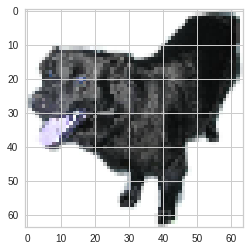

In [ ]:
print(y_train[0])
if y_train[0] == 1:
  print('doge')
else:
  print('cat')
plt.imshow(X_train[0])

In [ ]:
# Normalize the data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

X_train.reshape(-1, ROWS, COLS, 1)
X_val.reshape(-1, ROWS, COLS, 1)
X_test.reshape(-1, ROWS, COLS, 1)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## image_dataset_from_directory

In [ ]:
# Generate Dataset

image_size = (224, 224)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=True
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    labels=None,
    image_size=image_size,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 12500 files belonging to 1 classes.


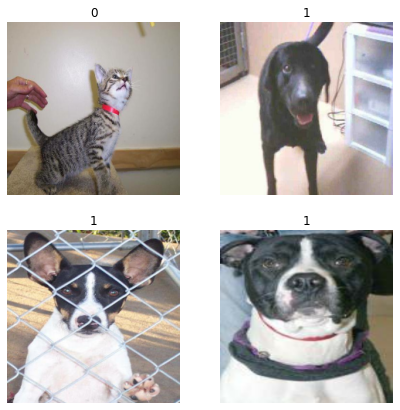

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
